In [1]:
import copy
from itertools import product
from classification_refined import classify
from processing import *
from readfiles import *
from decision import filter_summary
from subgraphclass import make_solver_summary
from sklearn.model_selection import train_test_split
from classification_refined import *
import networkx as nx
from readfiles import *
from metrics import *

num = 84  # number of nodes in the graph
tri = int(num * (num + 1) * 0.5)  # we want only the upper diagonal parts since everything below diagonal is 0
big5 = ['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']
edge_names = ['mean_FA', 'mean_strl', 'num_streamlines']
labels = ['Agreeableness', 'Openness', 'Conscientiousness', 'Neuroticism',
         'Extraversion']
mapping = {k: v for k, v in zip(labels, big5)}
mat = np.triu_indices(84)
mews = '/home/skapoor/Thesis/gmwcs-solver'
metrics = ['balanced_accuracy', 'accuracy', 'f1_weighted', 'roc_auc_ovr_weighted']
edges = ['fscores', 't_test']
# note: right now the matrix whole is not scaled, for computing the fscores and correlation coeff it has to be so.
y_train = computed_subjects()
X_train = generate_combined_matrix(tri,
                                  list(y_train.index))  # need to check indices till here then convert to numpy array
num_strls = X_train.iloc[:, 2 * tri:]
num_strls.columns = range(3570)

labels = ['Gender']
mapping = {'Gender': 'Gender'}
y_test = test_subjects()
X_test = generate_test_data(tri, y_test.index)

target = 'Gender'
feature = 'num_streamlines'
edge = 'fscores'
val = -0.01
thresh = 0
solver_node_wts = 'const'
max_num_nodes = 10
per = 1.15
choice = 'random'
classifier = 'SVC'
baseline_cases = set()
refit_metric = 'balanced_accuracy'
self_loops = False
feature_selection = 'baseline'
y_train_l = y_train[target]
y_test_l = y_test[target]
y_train_l = y_train_l.map({'M': 0, 'F': 1})
y_test_l = y_test_l.map({'M': 0, 'F':1})
case = (classifier, target, choice, edge, feature_selection, feature, per, refit_metric, self_loops)
X_train_l, X_test_l = edge_filtering(feature, X_train, X_test)
if not self_loops:
        X_train_inl = X_train_l.drop(X_train_l.columns[diag_flattened_indices(84)], axis=1)
        original = X_train_inl.columns - 2*3570
        X_test_inl = X_test_l.drop(X_test_l.columns[diag_flattened_indices(84)], axis=1)

X_train_inl, X_test_inl, arr, indices = transform_features(X_train_inl, X_test_inl, y_train_l, per,
                                                             edge)

Selected indices [ 288  367  445  598  628  747  892  978 1102 1114 1157 1598 1606 1642
 1647 1678 1714 1827 1835 1840 1841 1918 2046 2212 2262 2264 2290 2297
 2312 2313 2359 2404 2502 2627 2628 2629 2668 2782 2800 2830 3111]


In [2]:
indexes_in_triu = original[indices]

In [3]:
num_strls =  num_strls.iloc[:, indexes_in_triu]

In [4]:
indexes_in_triu

Int64Index([ 292,  372,  451,  606,  636,  757,  904,  991, 1117, 1129, 1173,
            1621, 1629, 1665, 1670, 1702, 1738, 1853, 1862, 1867, 1868, 1946,
            2076, 2246, 2297, 2299, 2325, 2332, 2348, 2349, 2396, 2441, 2542,
            2670, 2671, 2672, 2712, 2828, 2847, 2878, 3168],
           dtype='int64')

In [5]:
num_strls

,292,372,451,606,636,757,904,991,1117,1129,...,2441,2542,2670,2671,2672,2712,2828,2847,2878,3168
128127,15.0,0.0,6.0,6.0,16.0,26.0,15.0,259.0,3.0,2.0,...,67.0,51.0,329.0,662.0,145.0,24.0,234.0,6.0,34.0,158.0
129028,5.0,1.0,10.0,5.0,34.0,13.0,18.0,210.0,5.0,1.0,...,26.0,14.0,491.0,713.0,148.0,58.0,267.0,10.0,9.0,81.0
129331,11.0,0.0,18.0,10.0,50.0,39.0,49.0,207.0,19.0,2.0,...,73.0,40.0,598.0,1020.0,181.0,57.0,286.0,19.0,13.0,142.0
129937,7.0,3.0,27.0,22.0,112.0,28.0,22.0,272.0,9.0,7.0,...,35.0,38.0,340.0,969.0,141.0,37.0,121.0,38.0,18.0,114.0
130013,10.0,4.0,8.0,1.0,19.0,18.0,23.0,305.0,6.0,1.0,...,20.0,23.0,308.0,722.0,94.0,48.0,334.0,17.0,22.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207123,2.0,0.0,2.0,1.0,24.0,2.0,8.0,246.0,1.0,0.0,...,48.0,2.0,222.0,1063.0,159.0,82.0,138.0,10.0,23.0,137.0
207426,9.0,1.0,2.0,2.0,12.0,16.0,14.0,136.0,3.0,2.0,...,37.0,39.0,142.0,955.0,224.0,103.0,103.0,27.0,30.0,122.0
208125,27.0,6.0,29.0,7.0,55.0,34.0,88.0,188.0,31.0,4.0,...,61.0,54.0,108.0,936.0,217.0,63.0,204.0,25.0,106.0,88.0
208327,3.0,1.0,6.0,6.0,99.0,8.0,11.0,441.0,4.0,2.0,...,16.0,9.0,170.0,784.0,98.0,15.0,116.0,4.0,8.0,100.0


In [6]:
def find_indices(lin):
    d1 = {}
    mat = np.triu_indices(84)
    nondiag = list(set(range(3570)).difference(set(diag_flattened_indices(84))))
    for idx in lin: 
        for i in range(len(mat[0])):
            if i == idx:
                d1[idx] = (mat[0][i], mat[1][i])
    return d1

In [7]:
d1 = find_indices(indexes_in_triu)

In [8]:
indexes_in_triu

Int64Index([ 292,  372,  451,  606,  636,  757,  904,  991, 1117, 1129, 1173,
            1621, 1629, 1665, 1670, 1702, 1738, 1853, 1862, 1867, 1868, 1946,
            2076, 2246, 2297, 2299, 2325, 2332, 2348, 2349, 2396, 2441, 2542,
            2670, 2671, 2672, 2712, 2828, 2847, 2878, 3168],
           dtype='int64')

In [9]:
len(arr)

3486

In [10]:
original

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3556, 3557, 3558, 3559, 3561, 3562, 3563, 3565, 3566, 3568],
           dtype='int64', length=3486)

In [11]:

edges = list(d1.values())
links = np.zeros((len(edges),3))


mapping = {}
g = nx.Graph()
g.add_edges_from(edges)


for i in range(len(g.nodes)):
    mapping[list(g.nodes)[i]] = i
tups = []


for i, edge, index in zip(range(len(indices)), g.edges, indexes_in_triu):
    links[i][0] = edge[0]
    links[i][1] = edge[1]
    links[i][2] = num_strls.loc[:, index].mean()
    tups.append((edge[0], edge[1], num_strls.loc[:, index].mean()))
    
links = pd.DataFrame(links, columns=['source', 'target', 'value'])
links = links.astype(int)
links.head()
d1 = corresp_label_file('fs_default.txt')
vals = []
for node in g.nodes:
    vals.append(d1[node+1]) #since in the file the name starts from 1 and nodes from 0 in nx
nodes = pd.DataFrame(zip(range(len(g.nodes)),vals, range(len(g.nodes))), columns=['index', 'name', 'group'])

attr = {}
ll = {}
for node in g.nodes:
    attr[node] = {}
    attr[node]['label'] = d1[node+1] 
    g.nodes[node]['label'] = d1[node+1]
    ll[node] = d1[node+1]
    
g.add_weighted_edges_from(tups)
g.nodes

NodeView((3, 46, 4, 5, 7, 76, 9, 11, 12, 61, 14, 58, 15, 33, 22, 26, 34, 70, 75, 23, 82, 25, 78, 29, 35, 27, 56, 36, 38, 64, 71, 39, 83, 42, 45, 47, 43, 60))

In [12]:
indices # are the position in the original array without self loops

array([ 288,  367,  445,  598,  628,  747,  892,  978, 1102, 1114, 1157,
       1598, 1606, 1642, 1647, 1678, 1714, 1827, 1835, 1840, 1841, 1918,
       2046, 2212, 2262, 2264, 2290, 2297, 2312, 2313, 2359, 2404, 2502,
       2627, 2628, 2629, 2668, 2782, 2800, 2830, 3111])

In [13]:
np.argmax(arr)

2313

In [14]:
width = np.array(arr[indices]).reshape(1,-1)[0]

In [15]:
max(width)

0.372

In [16]:
edge_weights = []
for u,v in g.edges:
    edge_weights.append(g[u][v]['weight'])

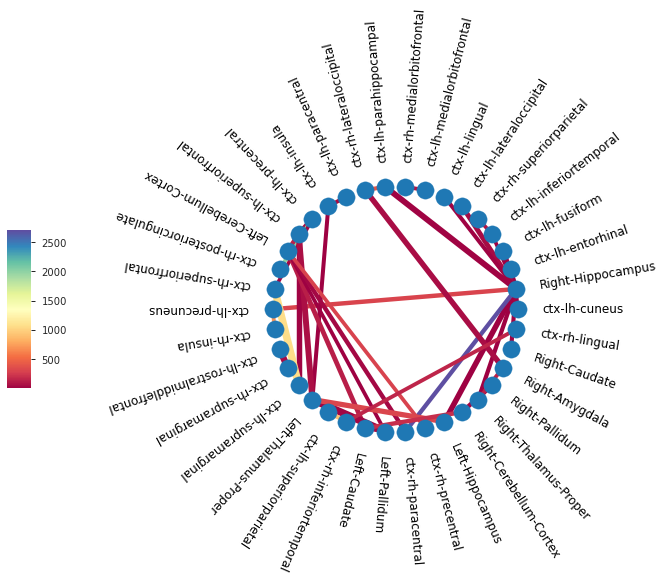

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

minima = min(edge_weights)
maxima = max(edge_weights)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima)
mapper = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('Spectral'))
color = []
for v in edge_weights:
    color.append(mapper.to_rgba(v))
n = len(g.nodes)
G = g
node_list = list(g.nodes)
angle = []
angle_dict = {}
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]


# figsize is intentionally set small to condense the graph
fig, ax = plt.subplots(figsize=(11,11))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

nx.draw(G,pos=pos,with_labels=False, ax=ax, edge_color=color, edge_cmap=mapper.cmap, vmin=minima,
                        vmax=maxima, font_size=18, width=width*20)
description = nx.draw_networkx_labels(G,pos,labels=ll)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.2+bbdata.width/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)
cbaxes = fig.add_axes([0.01, 0.4, 0.03, 0.2])  # This is the position for the colorbar
cb = plt.colorbar(mapper, cax = cbaxes)
plt.savefig('outputs/figures/baseline_42f_10nodes.png')
plt.show()

In [18]:
print(len(G.nodes))

38


In [19]:
len(G.edges)

41

In [20]:

ip = BrainGraph('fscores', 'num_streamlines', 'const', 'Gender', 10, -0.01, 0)
feature_indices = ip.read_from_file(mews, False)
#ip.visualize_graph(mews, False, plotting_options=graph_options('red',10, 'yellow', 2, 1.5),
#                   figs=(10,6))
G = ip

In [21]:
num_strls = X_train.iloc[:, 2 * tri:]

In [22]:
d1 = find_indices(feature_indices)
ew = G.edge_weights

In [23]:
tups = []
nums = []
d1 = find_indices(feature_indices)
for edge, index in zip(G.edges, feature_indices):
    tups.append((edge[0], edge[1], num_strls.iloc[:, index].mean()))
    nums.append(num_strls.iloc[:, index].mean())

In [24]:
G.add_weighted_edges_from(tups)

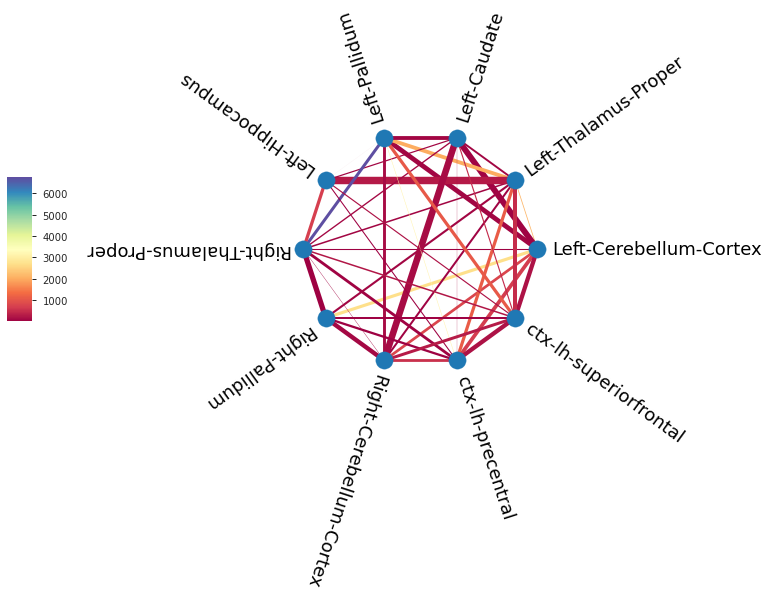

In [25]:
minima = min(nums)
maxima = max(nums)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima)
mapper = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('Spectral'))
color = []
for v in nums:
    color.append(mapper.to_rgba(v))
    
    
n = len(G.nodes)
node_list = list(G.nodes)
angle = []
angle_dict = {}
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

labels = {}
for node, i in zip(G.nodes, range(len(G.nodes))):
    labels[node] = G.node_labels[i]
# figsize is intentionally set small to condense the graph
fig, ax = plt.subplots(figsize=(11.5,10))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

nx.draw(G,pos=pos,with_labels=False, ax=ax, edge_color=color, edge_cmap=mapper.cmap, vmin=minima,
                        vmax=maxima, width=[i*20 for i in ew], rotate=60)
description = nx.draw_networkx_labels(G,pos,labels=labels, font_size=18)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.2+bbdata.width/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)
cbaxes = fig.add_axes([0.001, 0.4, 0.03, 0.2])  # This is the position for the colorbar
cb = plt.colorbar(mapper, cax = cbaxes)
plt.savefig('outputs/figures/solver_10nodes_strls.png')
plt.show()

In [26]:
len(G.edges)

40

(array([5., 6., 6., 5., 6., 7., 1., 2., 1., 1.]),
 array([0.001 , 0.0381, 0.0752, 0.1123, 0.1494, 0.1865, 0.2236, 0.2607,
        0.2978, 0.3349, 0.372 ]),
 <a list of 10 Patch objects>)

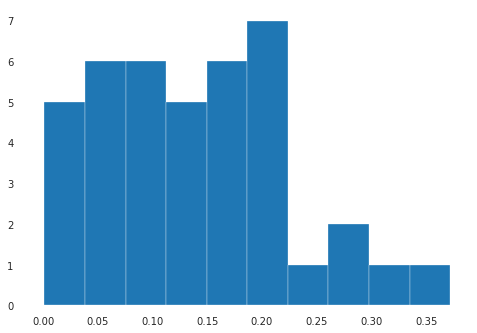

In [27]:
plt.hist(ew)

(array([16., 10.,  3.,  2.,  5.,  1.,  1.,  1.,  0.,  2.]),
 array([0.182, 0.201, 0.22 , 0.239, 0.258, 0.277, 0.296, 0.315, 0.334,
        0.353, 0.372]),
 <a list of 10 Patch objects>)

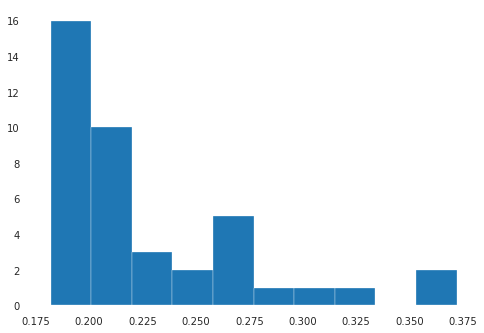

In [28]:
plt.hist(width)